In [1]:
import numpy as np

# Returns a copy of data which is normalized around mean of spinal base point
def normalize_spine_base(data):
    b = np.copy(data)
    spine = np.zeros(3)
    for i in range(3):
       spine[i] = np.mean(b[:, i])
    m, n = b.shape
    for i in range(n):
       b[:, i] -= spine[i % 3]
    return b

# Pulls up torso skeleton data from a general skeleton file, and normalizes it using normalize_spine_data()
def load_skeleton_data(filename):
    data = np.loadtxt(filename, dtype='float', delimiter=',', skiprows=1, usecols=(9, 10, 11, 18, 19, 20, 27, 28, 29, 36, 37, 38, 45, 46, 47, 54, 55, 56, 63, 64, 65, 72, 73, 74, 81, 82, 83, 90, 91, 92, 99, 100, 101, 108, 109, 110, 189, 190, 191))
    return normalize_spine_base(data)

In [2]:
n_data_1 = load_skeleton_data('test/head_nod/test1.csv')
n_data_2 = load_skeleton_data('test/head_nod/test2.csv')

In [3]:
print(n_data_1.shape, n_data_2.shape)

(21, 39) (16, 39)


In [4]:
from dtw import dtw

In [5]:
dist, cost, acc, path = dtw(n_data_1, n_data_2, dist=lambda x, y: np.linalg.norm(x - y))

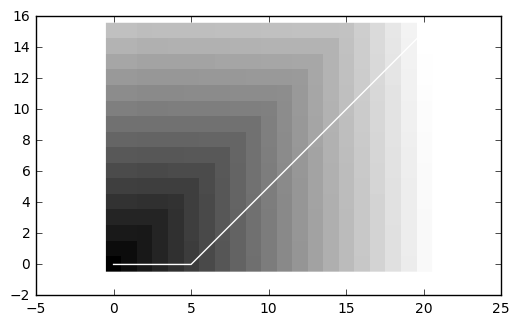

In [10]:
import matplotlib.pyplot as plt
plt.imshow(acc.T, origin='lower', cmap="gray", interpolation='nearest')
plt.plot(path[0], path[1], 'w')

In [9]:
%matplotlib inline